# **IEOR 4571 Fall 2020 Homework2 Report**


- Hu, Bo (uni: bh2569)
- Qin, Rui (uni: rq217)
- Yuan, Shuibenyang (uni: sy2938)

In [1]:
%load_ext autoreload
%autoreload 2 

#standard libs
import sys
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from os import path
import matplotlib.pyplot as plt

#plt env
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

#local env
sys.path.append('../')
from src.utils import loading, Spark
data_path = path.join('..', 'data')

# create spark session
spark = Spark()

Spark UI address http://127.0.0.1:4040


# Objective

**Objective function**

The goal is to create lists of movies that users might be interested in. 

**Metrics**

* Root Mean Square Error (RMSE): $RMSE = \sqrt{\frac{\sum_{(u, j) \in E}^{} e_{uj}^2}{\lvert E \rvert}}$, where $e_{ij} = \hat{r}_{uj} - r_{uj}$.

* Accuracy: ratio of ratings such that both predicted value and actual value larger or equal to 3 or both predicted value and actual value less than 3.

* Coverage: ratio of users or movies whose number of both predicted values and actual values larger or equal to 3 larger or equal to k.

**Intended users**

The recommendation system is created for the general audience so that everyone who enjoys movies benefits from the system.

**Business rules**

In order to keep the user entertained rather than only focusing on what they already know, one business rule we come up with is to include at least two different genres when recommending k movies even though the predicted rating might be low. Since our business goal is to benefit all movie lovers, we believe letting them expose to as many genres as possible is fundamental.

**Performance requirements**

For performance, we would like to serve the online queries in real time. For model based algorithms, it’s fine to train it offline and then serve the model online. However, for memory based models, it is hard to meet the performance requirements unless implementing more sophisticated algorithms like approximate nearest neighbor. 

In order to interpret models better, we decide to make the matrix factorization algorithm to only produce non-negative matrices. In that case, we would be able to identify some elements that are important for the algorithm to learn users’ behaviours (higher value in the matrices would produce higher ratings).

# The Sample

**sampling methodology**

We perform sampling w.r.t Conditional Matrix Sampling, in which, we will sample the matrix of $M$ user indices and $N$ movie indices filtering out users who do not have at least $i$ ratings and movies which do not have at least $j$ ratings. If numbers of users and movies are not meet the minimal requirements $M$ and $N$, we will keep sampling process with increased matrix indices number of user and movie until users and movies meet minimal requirements $M$ and $N$.

**generating sample**

to generate sample, run following lines (The sample has been already stored under `[project_directory]/raw/sample.csv`):

```bash
cd [project_directory]
python main.py download sample
```

## Load Sample

In [2]:
# load sample data from '/data/raw/sample.csv'
datas = loading(spark, path.join(data_path, 'raw'))
sample = datas['sample']

## Sample Objectives

In [3]:
print(f'''
            number of data points in the sample: {sample.count()},
            number of unique users in the sample: {sample.select('userId').distinct().count()},
            number of unique movies in the sample: {sample.select('movieId').distinct().count()},
            mean of number of movies a user rated:{sample.groupby('userId').agg(F.count('movieId').alias('cnt')).select(F.mean('cnt')).collect()[0][0]},
            mean of number of users a movie be rated: {sample.groupby('movieId').agg(F.count('userId').alias('cnt')).select(F.mean('cnt')).collect()[0][0]},
            average rating: {sample.select(F.mean('rating')).collect()[0][0]},
            standard deviation of rating: {sample.select(F.stddev('rating')).collect()[0][0]},
            average rating by user: {sample.groupby('userId').agg(F.mean('rating').alias('rating')).select(F.mean('rating')).collect()[0][0]},
            standard deviation of rating by user mean: {sample.groupby('userId').agg(F.mean('rating').alias('rating')).select(F.stddev('rating')).collect()[0][0]},
            average rating by movie: {sample.groupby('movieId').agg(F.mean('rating').alias('rating')).select(F.mean('rating')).collect()[0][0]},
            standard deviation of rating by movie mean: {sample.groupby('movieId').agg(F.mean('rating').alias('rating')).select(F.stddev('rating')).collect()[0][0]}
        ''')


            number of data points in the sample: 444289,
            number of unique users in the sample: 20000,
            number of unique movies in the sample: 1000,
            mean of number of movies a user rated:22.21445,
            mean of number of users a movie be rated: 444.289,
            average rating: 3.562069958968149,
            standard deviation of rating: 1.0467842419621054,
            average rating by user: 3.685826601448731,
            standard deviation of rating by user mean: 0.5225862364055156,
            average rating by movie: 3.290922029378176,
            standard deviation of rating by movie mean: 0.5133362661920545
        


# Methodology

We implemented two types of collaborative filtering techniques:

- Memory Based Collaborative Filtering
    
- Model Based Collaborative Filtering

## Baseline Model

**usage**

The source code of Baseline Model is under the file directory: `[project_directory]/src/baseline/baseline.py`

To use the predictor, `import Baseline() from src.baseline`

```python
###example
#train_schema: DataFrame[userId: string, movieId: string, rating: string]
#test_schema: DataFrame[userId: string, movieId: string, rating: string]
from src.baseline import Baseline
model = Baseline(base='user', usercol='userId', itemcol='movieId', ratingcol='rating')
model.fit(train)
prediction = model.predict(test)
#prediction_schema: DataFrame[userId: string, movieId: string, rating: float, prediction: float]
   
```

**implementation details**

The baseline model makes simple prediction by taking mean of user mean and item mean:

$R$ is defined as $R_{u,i} = \frac{\mu_u + \mu_i}{2}$ where u and i represents user and item accordingly.

## Memory Based Collaborative Filtering

**usage**

The source code of Memory Based Collaborative Filtering is under the file directory: `[project_directory]/src/memory_based/memory_based_cf.py`. 

To use the predictor, `import Memory_based_CF() from src.memory_based`

```python
###example
#spark: the spark session
#train_schema: DataFrame[userId: string, movieId: string, rating: string]
#test_schema: DataFrame[userId: string, movieId: string, rating: string]
from src.memory_based import Memory_based_CF
#user based
model = Memory_based_CF(spark, base='user', usercol='userId', itemcol='movieId', ratingcol='rating')
model.fit(train)
prediction = model.predict(test)
#item based
model = Memory_based_CF(spark, base='item', usercol='userId', itemcol='movieId', ratingcol='rating')
model.fit(train)
prediction = model.predict(test)
#prediction_schema: DataFrame[userId: string, movieId: string, rating: float, prediction: float]
   
```


**implementation details**

The data first transformed into sparse matrix representation, (user by item) if user based and (item by user) if item based.

The the prediction matrix $R$ is trained with following formula:

$R$ is defined as $R_{i, j} = \mu_i + \frac{\sum_{v\in P_i(j)}S(i, v)\cdot (r_{vj} - \mu_v)}{\sum_{v\in P_i(j)}|S(i, v)|}$

where $S$ is the Pearson Similarity Matrix

$S$ is defined as $S_{u,v} = \frac{\sum_{k\in I_u \cap I_v}(r_{uk} - \mu_u)(r_{vk} - \mu_v)}{\sqrt{\sum_{k\in I_u \cap I_v}(r_{uk} - \mu_u)^2}\sqrt{\sum_{k \in I_u \cap I_v}(r_{vk} - \mu_v)^2}}$

The algorithm is implemented with numpy array (for prediction) and scipy csr sparse matrix (for training). 

Every operation uses numpy matrix operations (aka. dot product, norm, etc) which optimizes the computational speed by trading off extra memories (for loop takes $\approx 10$ minutes to train and matrix operations takes $\approx 1$ minutes to train for our experimental sample in user based CF).

**user based collabrative filtering**

When R is (user by item) and S is (user by user), it is User Based Collabrative Filtering

**user based collabrative filtering**

When R is (item by user) and S is (item by item), it is Item Based Collabrative Filtering


## Model Based Collaborative Filtering

**usage**

The source code of Memory Based Collaborative Filtering is under the file directory: `[project_directory]/src/model_based/als.py`. 

To use the predictor, just `import Als() from src.model_based`

```python
###example
#train_schema: DataFrame[userId: string, movieId: string, rating: string]
#test_schema: DataFrame[userId: string, movieId: string, rating: string]

from src.model_based import Als

model = Als(userCol='userId', itemCol='movieId', ratingCol='rating', regParam=.01, seed=0, rank=10)
model.fit(train)
prediction = model.predict(test)

#prediction_schema: DataFrame[userId: string, movieId: string, rating: float, prediction: float]
   
```


**implementation detail**

The data first caseted userId and movieId into integers and then fit into `pyspark.ml.recommendation.ALS`.

Our implementation takes advantages of model based collaborative filtering algorithm implemented in `spark.ml`, in which users and products are described by a small set of latent factors that can be used to predict missing entries `spark.ml` uses the alternating least squares (ALS) algorithm to learn these latent factors.

Since there are many parameters in ALS of `spark.ml`, we will fix `nonnegative = True` since negative rating is not possible in our scenario, and we will only select `regParam`(scale of regulization term) and `rank`(number of hidden factors) to be tuned. (We also tried to tune `maxIter` parameter, but when `maxIter > 20` will blow up memory in our machine with large `rank`, and it takes much longer with nearly the same results, so we will keep `maxIter` with default `=10`.)

# Evaluation

## Cross Validation Setup

**general setup**

we will first setup a fixed splited dataset for all models: baseline, memory-based CF, and model-based CF.

With following splits based on every user:
- train, test : $75\%, 25\%$
- train, test : $50\%, 50\%$
- train, test : $25\%, 25\%$

For example, for (train, test: $75\%, 25\%$), we will retain first (older to newer) $75\%$ of every user's rating w.r.t their rating time as train set, and we will take the rest as test set.

The splitted data has already been stored under the file directory `[project_directory]/data/interim/`. The file alias following the pattern: `[train/test]_[0.xx_0.xx].csv`. For example, `train_0.75_0.25.csv` means the training set with $75\%$ train and $25\%$ test split.

To generate the splitted data, run following lines in bash:

```bash
cd [project_directory]
python main.py train-test-split
```


**model based CF**

For model based CF, we will do additional hyper-parameter tuning with $10\%$ validation set from train set to get the best possible parameter.

In [4]:
data = loading(spark, '../data/interim')
splits = ['0.75_0.25', '0.5_0.5', '0.25_0.75']
for split in splits:
    print(f'''
            number of rows in train set of {split}: {data['train_'+split].count()},
            number of rows in test set of {split}:  {data['test_'+split].count()}
            ''')


            number of rows in train set of 0.75_0.25: 339624,
            number of rows in test set of 0.75_0.25:  104665
            

            number of rows in train set of 0.5_0.5: 226271,
            number of rows in test set of 0.5_0.5:  218018
            

            number of rows in train set of 0.25_0.75: 118148,
            number of rows in test set of 0.25_0.75:  326141
            


## Evaluation Metrics

Our metrics are as follow:

* Root Mean Square Error (RMSE): $RMSE = \sqrt{\frac{\sum_{(u, j) \in E}^{} e_{uj}^2}{\lvert E \rvert}}$, where $e_{ij} = \hat{r}_{uj} - r_{uj}$.

* Accuracy: ratio of ratings such that both predicted value and actual value larger or equal to 3 or both predicted value and actual value less than 3.

* Coverage: ratio of users or movies whose number of both predicted values and actual values larger or equal to 3 larger or equal to k.

**choice of k in coverage**

Since mean of number of movies a user rated:22.21445 and mean of number of users a movie be rated: 444.289, We will choose $k = 10$ for user coverage and $k = 100$ for item coverage.

## Paramer Tuning for ALS

we used following parameters as our grid search for paramerter tuning with $10\%$ validation set of train set to get the best possible parameter of `regParam` and `rank`

``` json
parameters = {
    "regParam": [0.01, 0.05, 0.1, 0.15],
    "rank": [10, 50, 100, 150, 200]
}
```

The details of parameter turning can be found in this [notebook](./als_parameter_tuning.ipynb)

In [5]:
tuning_res = pd.read_csv(path.join(data_path, 'processed', 'tuning_result','als_parameter_tuning.csv'))
tuning_res['regParam'] = tuning_res['(regParam, rank)'].str.strip('()').str.split(',').str[0].astype(float)
tuning_res['rank'] = tuning_res['(regParam, rank)'].str.strip('()').str.split(',').str[1].astype(int)
tuning_res = tuning_res.set_index('(regParam, rank)')

**the best paramter**

In [10]:
optimals = []
for split in ['0.75_0.25', '0.5_0.5', '0.25_0.75']:
    subset = tuning_res[tuning_res.split == split].drop('split', axis = 1)
    print(f'''with split = {split}''')
    for col in ['rmse', 'accuracy', 'coverage_user', 'coverage_item']:
        if col == 'rmse':
            optimal = subset[col].idxmin()
        else:
            optimal = subset[col].idxmin()
        print(f'''
                    for {col}: 
                    the optimal parameter is {optimal}
                ''')
        optimals.append(optimal)

with split = 0.75_0.25

                    for rmse: 
                    the optimal parameter is (0.15, 10)
                

                    for accuracy: 
                    the optimal parameter is (0.01, 50)
                

                    for coverage_user: 
                    the optimal parameter is (0.15, 150)
                

                    for coverage_item: 
                    the optimal parameter is (0.01, 50)
                
with split = 0.5_0.5

                    for rmse: 
                    the optimal parameter is (0.15, 10)
                

                    for accuracy: 
                    the optimal parameter is (0.05, 50)
                

                    for coverage_user: 
                    the optimal parameter is (0.15, 50)
                

                    for coverage_item: 
                    the optimal parameter is (0.01, 50)
                
with split = 0.25_0.75

                    for rmse: 
                

In [11]:
display(pd.Series(optimals).value_counts())

(0.01, 50)     4
(0.15, 10)     3
(0.05, 50)     2
(0.15, 150)    1
(0.15, 50)     1
(0.01, 100)    1
dtype: int64

The best parameter is regparam = 0.01 and rank = 50 since it has the most frequency.

## Evaluation Execution

To reduce the tediousness of final report, please see the process of Evaluation Executation in this [notebook](./evaluation_execution.ipynb)

## Evaluation Results w.r.t metrics

In [12]:
#loading results
results = loading(spark, path.join(data_path, 'processed', 'evaluation_result'))
for k in results.keys():
    results[k] = results[k].toPandas()
    results[k].columns = ['metrics', 'train', 'test', 'split']
grouped_results = {'rmse': pd.DataFrame(columns = ['model', 'train_proportion', 'train_rmse', 'test_rmse']),
                   'accuracy': pd.DataFrame(columns = ['model', 'train_proportion', 'train_accuracy', 'test_accuracy']),
                   'coverage_user':pd.DataFrame(columns = ['model', 'train_proportion', 'train_coverage_user', 'test_coverage_user']),
                   'coverage_item': pd.DataFrame(columns = ['model', 'train_proportion', 'train_coverage_item', 'test_coverage_item'])
                }

for metric in ['rmse', 'accuracy', 'coverage_user', 'coverage_item']:
    for split, prop_train in zip(['0.75_0.25', '0.5_0.5', '0.25_0.75'], [.75, .5, .25]):
        for model in ['baseline', 'userbased', 'itembased', 'modelbased']:
            df = results[model+'_eval_res']
            res = df[(df.split == split) & (df.metrics == metric)]
            ds = pd.Series({
                'model': model,
                'train_proportion': prop_train,
                'train_'+ metric:round(float(res.iloc[0].loc['train']), 2),
                'test_'+metric: round(float(res.iloc[0].loc['test']), 2)
            })
            grouped_results[metric] = grouped_results[metric].append(ds, ignore_index=True)

def mean_metrics(df, metric):
    return df.groupby('model')[['train_'+metric, 'test_'+metric]].mean().round(2)

def plot_split_metric(df, metric):
    for model in df.model.unique():
        subset = df[df.model == model]
        plt.plot(subset.train_proportion, subset['train_'+metric], label = model)
        plt.legend()
    plt.title(f'train {metric} vs. training proportion')
    plt.xlabel(f'train {metric}')
    plt.ylabel('train proportion')
    plt.show()
    for model in df.model.unique():
        subset = df[df.model == model]
        plt.plot(subset.train_proportion, subset['test_'+metric], label = model)
        plt.legend()
    plt.title(f'test {metric} vs. training proportion')
    plt.xlabel(f'test {metric}')
    plt.ylabel('train proportion')
    plt.show()

### RMSE Results

**mean train rmse and test rmse with different models**

In [13]:
rmse_grouped_results = grouped_results['rmse']
display(mean_metrics(rmse_grouped_results, 'rmse'))

,train_rmse,test_rmse
model,,
baseline,0.85,0.92
itembased,0.89,0.91
modelbased,0.20,1.15
userbased,0.80,0.93


In [14]:
# todo analysis

**train rmse and test rmse with different training proportion across different models**

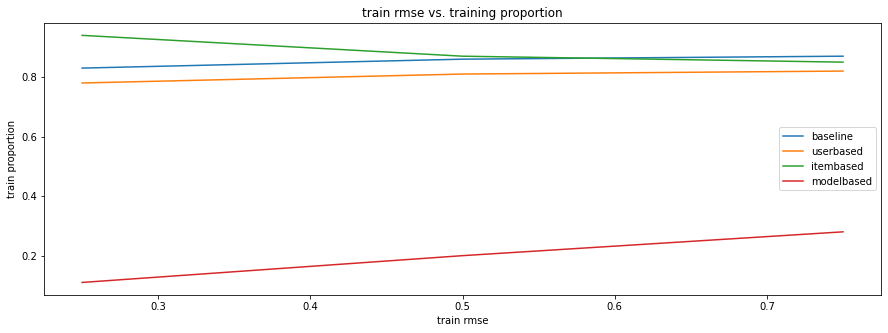

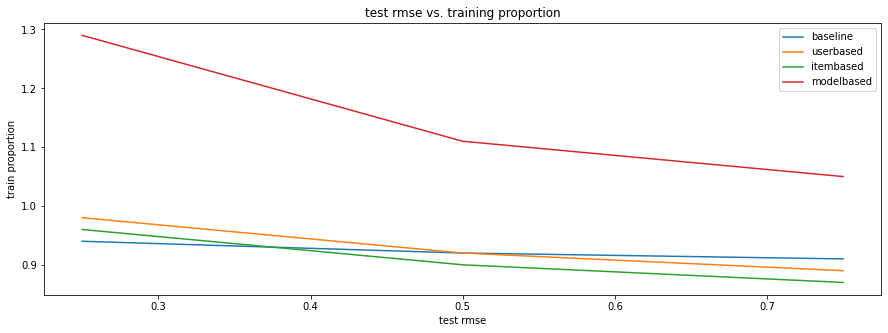

In [15]:
plot_split_metric(rmse_grouped_results, 'rmse')

In [16]:
# todo analysis

### Accuracy Results

In [17]:
accuracy_grouped_results = grouped_results['accuracy']
display(mean_metrics(accuracy_grouped_results, 'accuracy'))

,train_accuracy,test_accuracy
model,,
baseline,0.87,0.83
itembased,0.84,0.80
modelbased,0.91,0.69
userbased,0.85,0.79


In [18]:
#todo analysis

**train accuracy and test accuracy with different training proportion across different models**

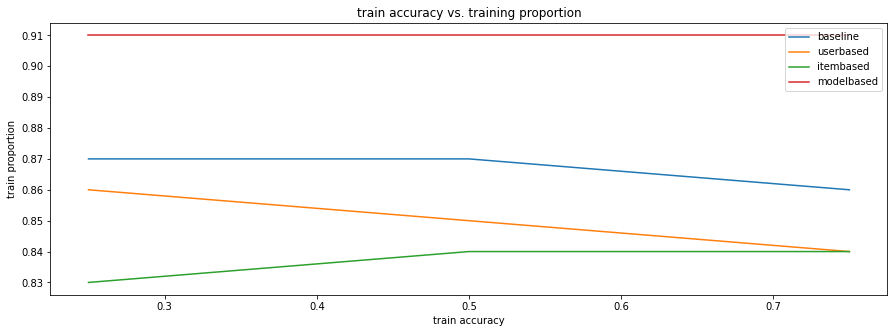

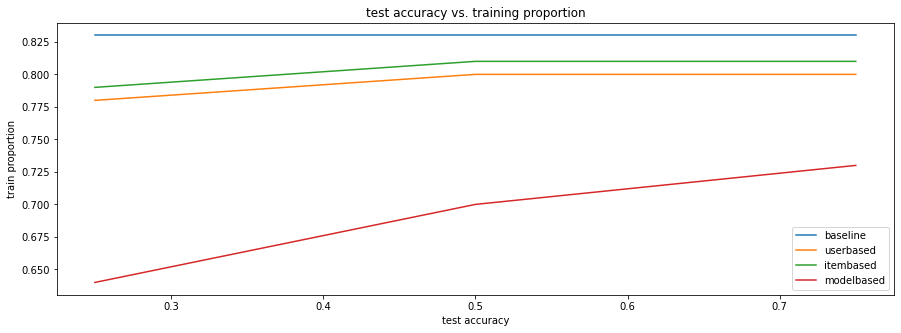

In [19]:
plot_split_metric(accuracy_grouped_results, 'accuracy')

In [20]:
#todo analysis

### Coverage User Results

In [21]:
coverage_user_grouped_results = grouped_results['coverage_user']
display(mean_metrics(coverage_user_grouped_results, 'coverage_user'))

,train_coverage_user,test_coverage_user
model,,
baseline,0.29,0.27
itembased,0.28,0.25
modelbased,0.27,0.24
userbased,0.28,0.26


In [22]:
#todo analysis

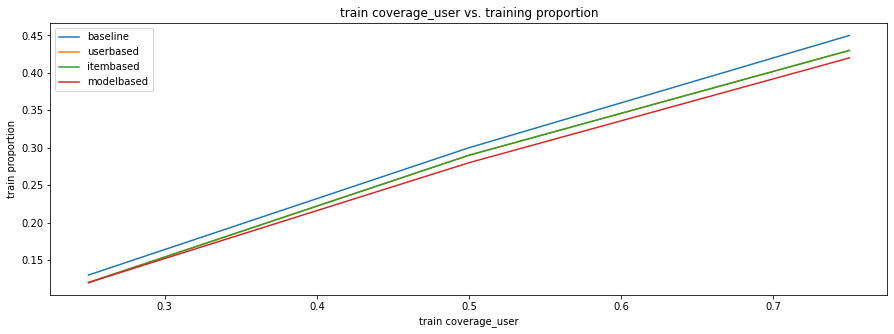

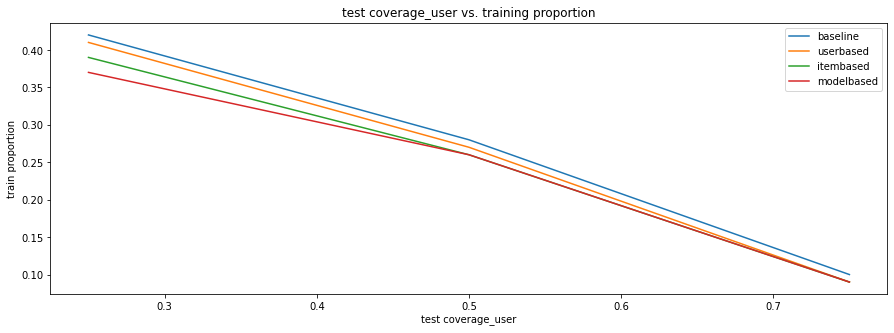

In [23]:
plot_split_metric(coverage_user_grouped_results, 'coverage_user')

In [24]:
#todo analysis

### Coverage Item Results

In [25]:
coverage_item_grouped_results = grouped_results['coverage_item']
display(mean_metrics(coverage_item_grouped_results, 'coverage_item'))

,train_coverage_item,test_coverage_item
model,,
baseline,0.25,0.29
itembased,0.23,0.27
modelbased,0.23,0.27
userbased,0.23,0.26


In [26]:
#todo analysis

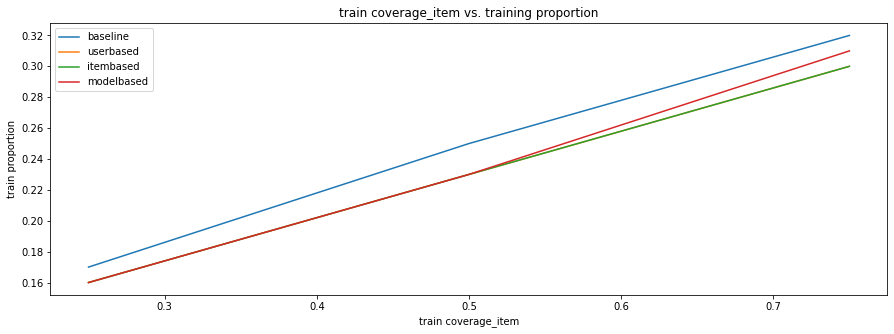

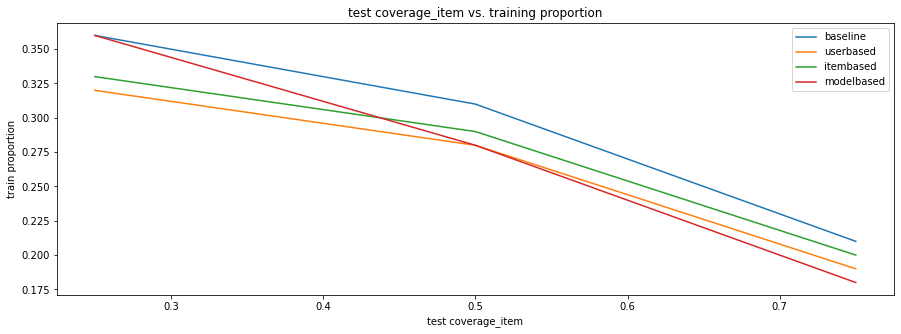

In [27]:
plot_split_metric(coverage_item_grouped_results, 'coverage_item')

In [28]:
#todo analysis

## Evaluation Results w.r.t time

In [29]:
#loading result and process the result into format
time_res = {model : pd.read_csv(path.join(data_path, 'processed', 'evaluation_result', model+'_time_res.csv'))\
 for model in ['baseline', 'userbased', 'itembased', 'modelbased']}
for k in time_res.keys():
    time_res[k].columns = ['stage', 0.75, 0.5, 0.25]
    time_res[k] = time_res[k].set_index('stage')
mean_time = pd.DataFrame(columns = ['baseline', 'userbased', 'itembased', 'modelbased'])
for model in ['baseline', 'userbased', 'itembased', 'modelbased']:
    mean_time[model] = time_res[model].mean(axis =1)

**mean training/inference time of different models**

In [30]:
display(mean_time)

,baseline,userbased,itembased,modelbased
stage,,,,
training time,0.069045,35.334460,5.528973,8.550644
inference train time,0.047403,8.187554,7.571961,0.024610
inference test time,0.039786,7.619407,7.207684,0.020605


In [31]:
#todo analysis

**training time scalibility**

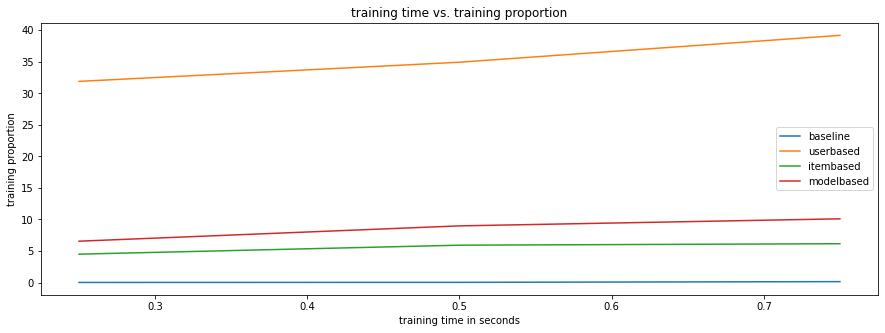

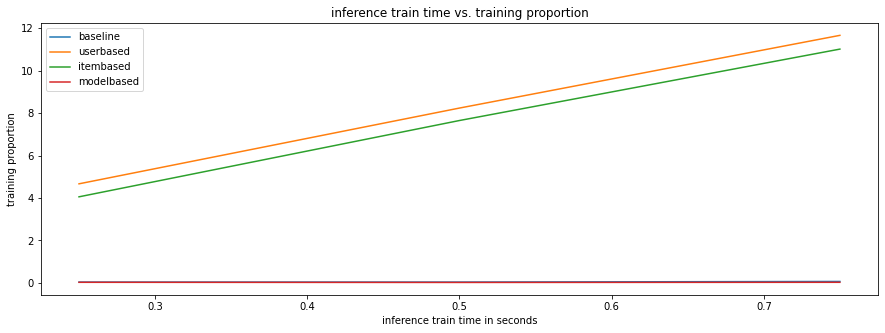

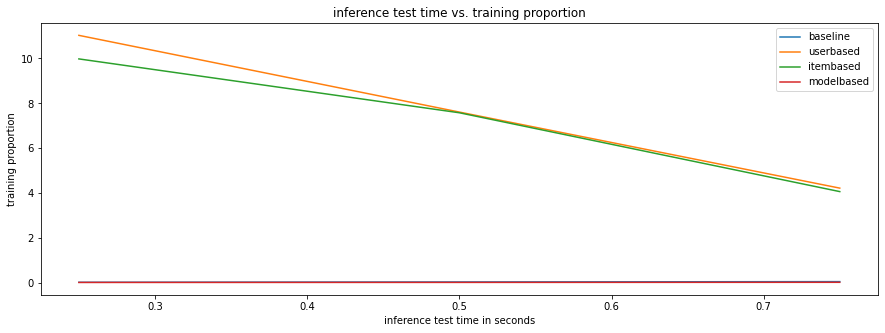

In [32]:
for stage in ['training time', 'inference train time', 'inference test time']:
    pd.DataFrame({model: time_res[model].T[stage]\
    for model in ['baseline', 'userbased', 'itembased', 'modelbased']}).plot()
    plt.title(f'{stage} vs. training proportion')
    plt.xlabel(f'{stage} in seconds')
    plt.ylabel('training proportion')
    plt.show()

In [33]:
#todo analysis

## Prediction Distribution

In [34]:
predictions = loading(spark, path.join(data_path, 'processed', 'prediction'))

for k in predictions.keys():
    predictions[k] = predictions[k].select('userId', 'movieId', 
                                           F.col('rating').cast('float'), 
                                           F.col('prediction').cast('float'))\
                                    .toPandas()

In [35]:
def rating_distribution(raw):
    fig, ax = plt.subplots(1,1)
    raw.prediction.plot(kind='hist',bins=np.arange(0,6,0.5),ax=ax,alpha=0.7,density=True,label='predicted')
    raw.rating.plot(kind='hist',bins=np.arange(0,6,0.5),ax=ax,alpha=0.7,density=True,label='actual')
    plt.legend()
    plt.xlabel("Ratings")
    plt.ylabel("% of Ratings")
    plt.title("Distribution of Actual Ratings vs. Predicted Ratings")
    plt.show()
    return

def plot_pipeline(splits, model, predictions):
    for s in splits:
        print(f'with {s} split, the plot of distribution is: ')
        k = s + '_' + model + '_' + 'pred'
        rating_distribution(predictions[k])

### Baseline Model Prediction Distribution

with 0.75_0.25 split, the plot of distribution is: 


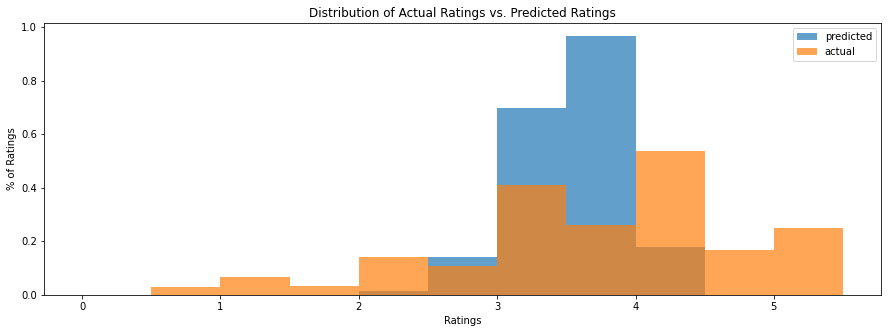

with 0.5_0.5 split, the plot of distribution is: 


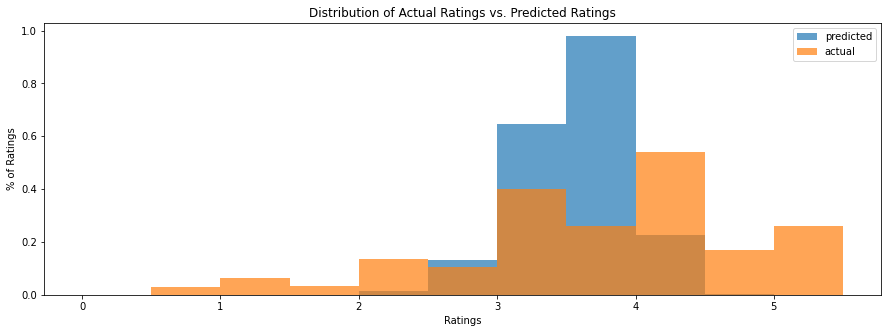

with 0.25_0.75 split, the plot of distribution is: 


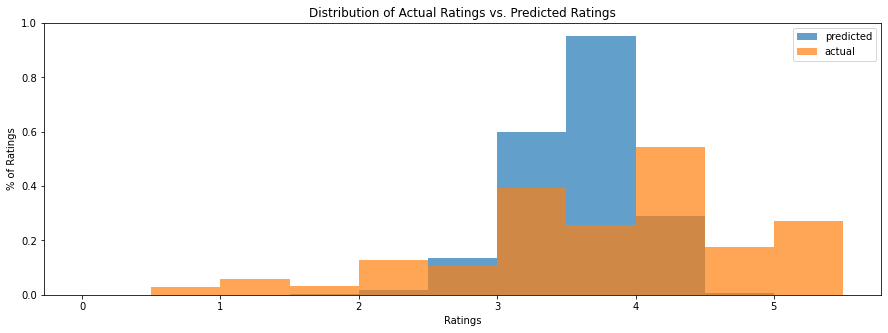

In [36]:
plot_pipeline(['0.75_0.25', '0.5_0.5', '0.25_0.75'], 'baseline', predictions)

In [37]:
#todo analysis

### User Based CF Prediction Distribution

with 0.75_0.25 split, the plot of distribution is: 


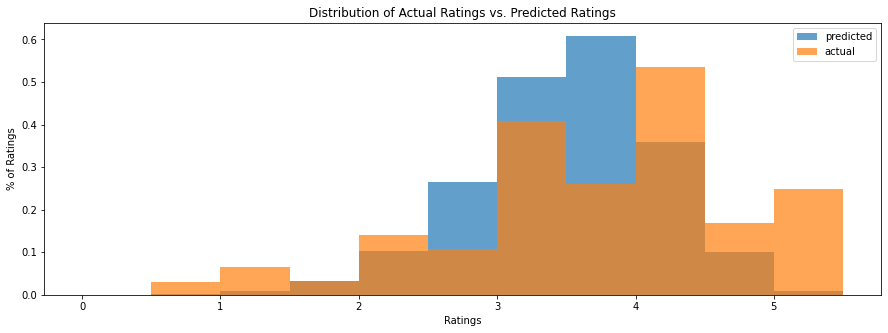

with 0.5_0.5 split, the plot of distribution is: 


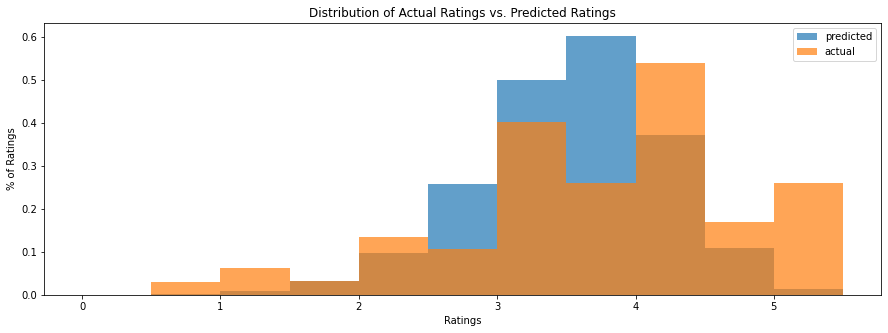

with 0.25_0.75 split, the plot of distribution is: 


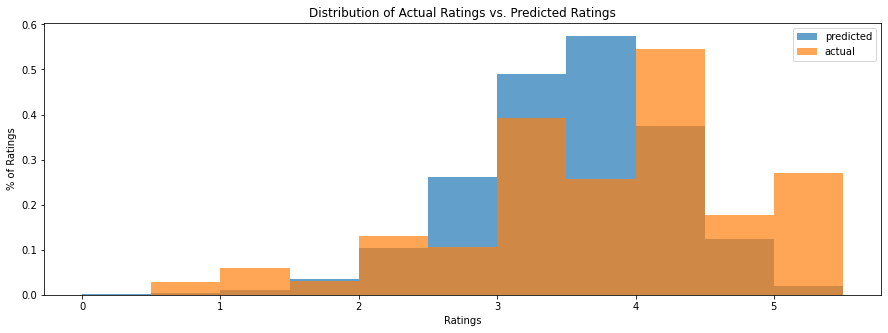

In [38]:
plot_pipeline(['0.75_0.25', '0.5_0.5', '0.25_0.75'], 'userbased', predictions)

In [39]:
#todo analysis

### Item Based CF Prediction Distribution

with 0.75_0.25 split, the plot of distribution is: 


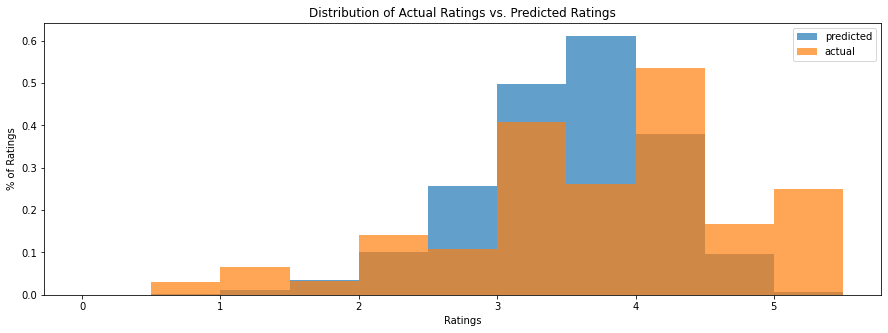

with 0.5_0.5 split, the plot of distribution is: 


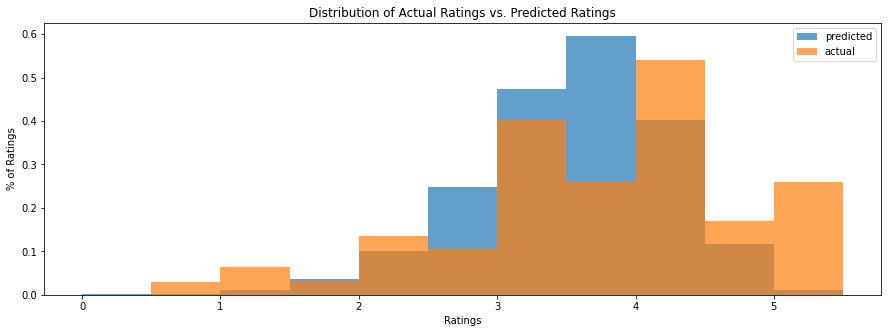

with 0.25_0.75 split, the plot of distribution is: 


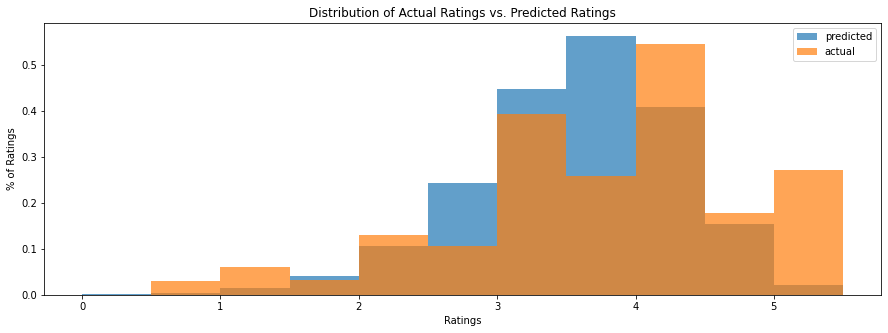

In [40]:
plot_pipeline(['0.75_0.25', '0.5_0.5', '0.25_0.75'], 'itembased', predictions)

In [41]:
#todo analysis

### Model Based CF Prediction Distribution

with 0.75_0.25 split, the plot of distribution is: 


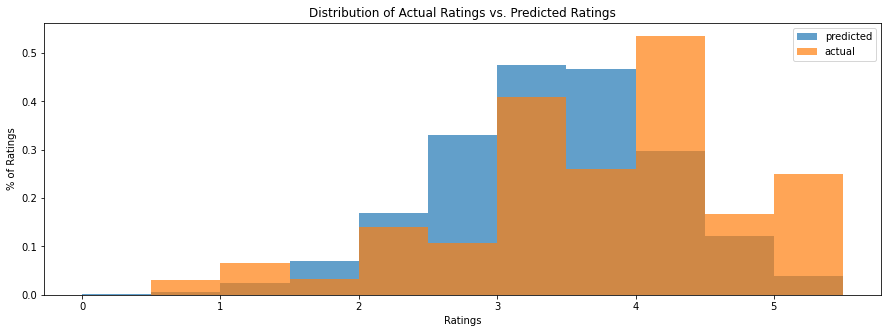

with 0.5_0.5 split, the plot of distribution is: 


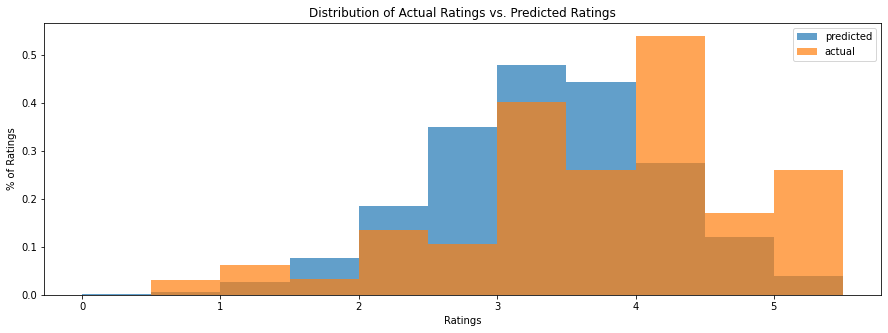

with 0.25_0.75 split, the plot of distribution is: 


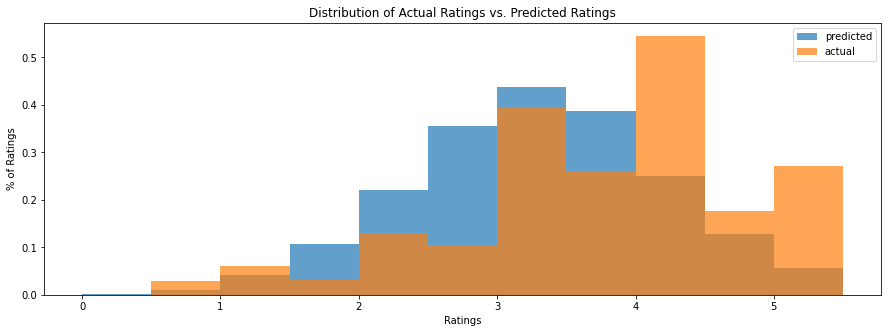

In [42]:
plot_pipeline(['0.75_0.25', '0.5_0.5', '0.25_0.75'], 'modelbased', predictions)

In [43]:
#todo analysis

## Prediction w.r.t Movie Genre (hypothesis)

In [45]:
movies = spark.read.csv(path.join(data_path, 'raw', 'movies.csv'),header=True)

predictions_spark = loading(spark, path.join(data_path, 'processed', 'prediction'))

for k in predictions_spark.keys():
    predictions_spark[k] = predictions_spark[k].select('userId', 'movieId', 
                                           F.col('rating').cast('float'), 
                                           F.col('prediction').cast('float'))

# helper to append genre to rating table
def append_genre(sample):
    copy = movies.withColumn("genre_lst",F.split("genres","\|").alias("genre_lst")) # add a new col of genres.split("|")
    with_genre = copy.join(sample,copy.movieId == sample.movieId).drop(sample.movieId)
    movie_genre = with_genre.select("movieId",F.explode("genre_lst").alias("genre"),"rating","prediction")
    return movie_genre

# func to create the table with genre, mean ratings, and mean pred
def mean_by_genre(with_pred):
    with_genre = append_genre(with_pred)
    avg = with_genre.groupBy("genre").agg(F.mean("rating").alias("avg_rating"),F.mean("prediction").alias("avg_prediction"))
    return avg

# func to plot 
def draw_mean_genre(avg):
    fig, ax = plt.subplots(1,1,figsize=(12,5))
    avg.toPandas().plot(x='genre',y=['avg_rating','avg_prediction'],kind='bar',ax=ax)
    plt.ylabel("rating")
    plt.legend(loc='lower right')
    plt.title("Average Ratings and Predictions for Genres")
    plt.show()
    return

def plot_genre(splits, model, predictions):
    for s in splits:
        print(f'with {s} split, the plot of distribution is: ')
        k = s + '_' + model + '_' + 'pred'
        draw_mean_genre(mean_by_genre(predictions_spark[k]))

### Baseline Prediction with Genre

with 0.75_0.25 split, the plot of distribution is: 


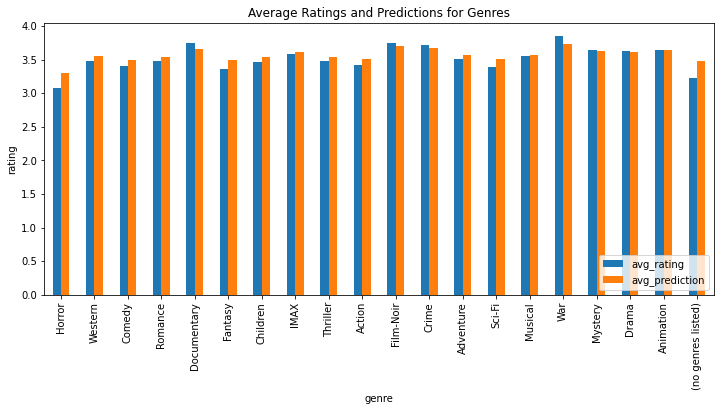

with 0.5_0.5 split, the plot of distribution is: 


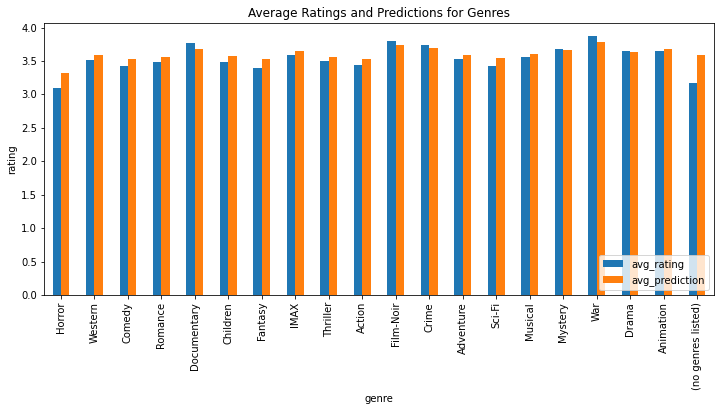

with 0.25_0.75 split, the plot of distribution is: 


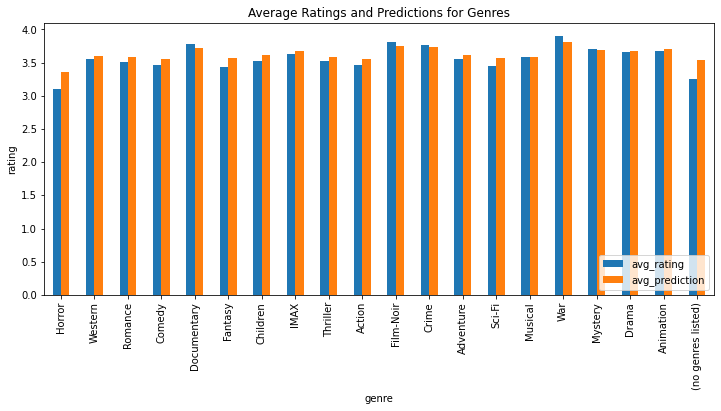

In [46]:
plot_genre(splits, 'baseline', predictions)

In [ ]:
#todo analysis

### User Based CF Prediction with Genre

with 0.75_0.25 split, the plot of distribution is: 


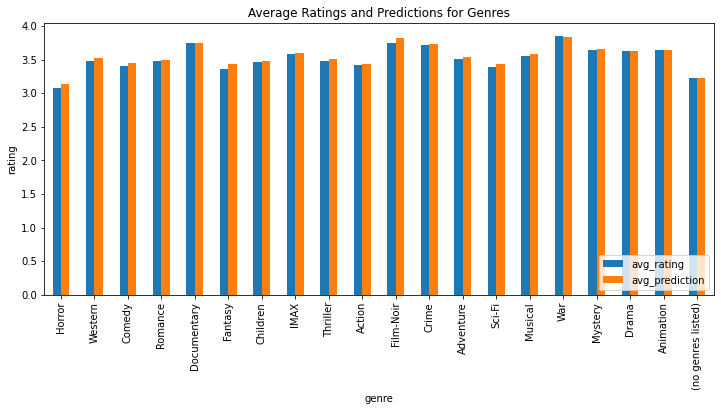

with 0.5_0.5 split, the plot of distribution is: 


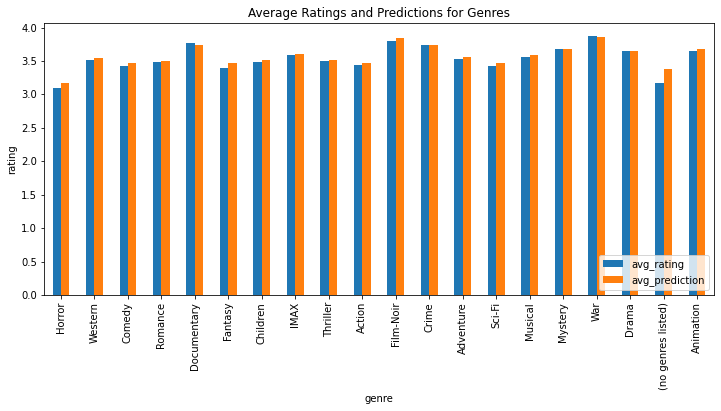

with 0.25_0.75 split, the plot of distribution is: 


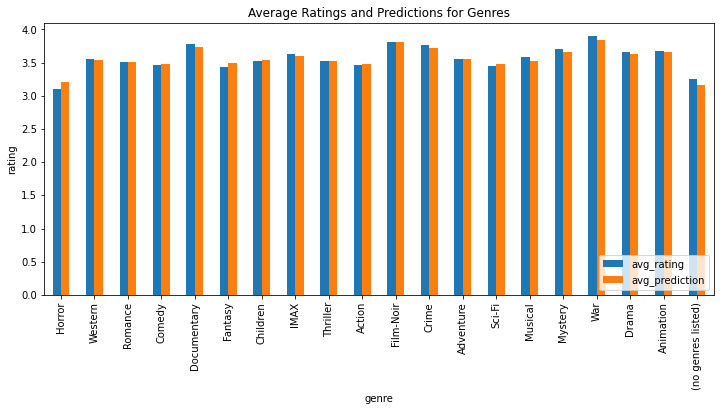

In [48]:
plot_genre(splits, 'userbased', predictions)

### Item Based CF Prediction with Genre

with 0.75_0.25 split, the plot of distribution is: 


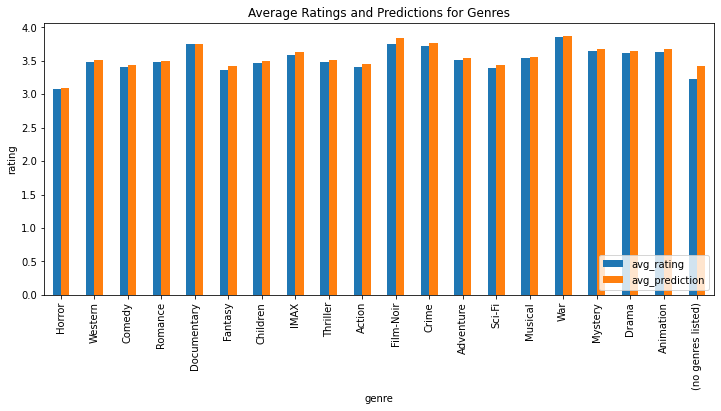

with 0.5_0.5 split, the plot of distribution is: 


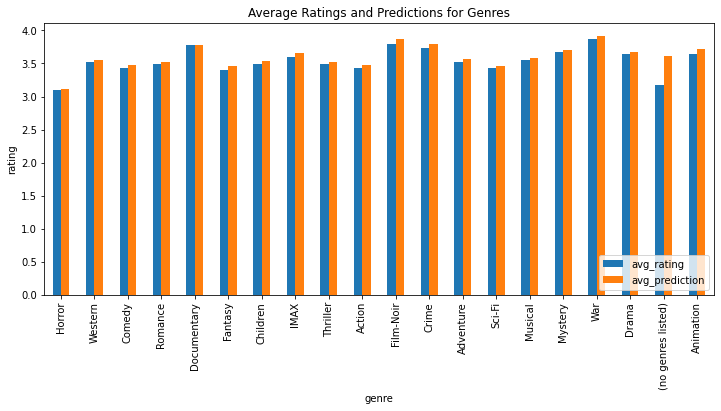

with 0.25_0.75 split, the plot of distribution is: 


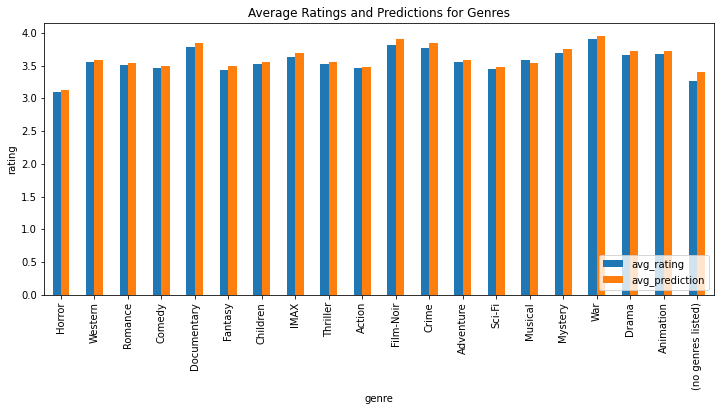

In [49]:
plot_genre(splits, 'itembased', predictions)

### Model Based CF Prediction with Genre

with 0.75_0.25 split, the plot of distribution is: 


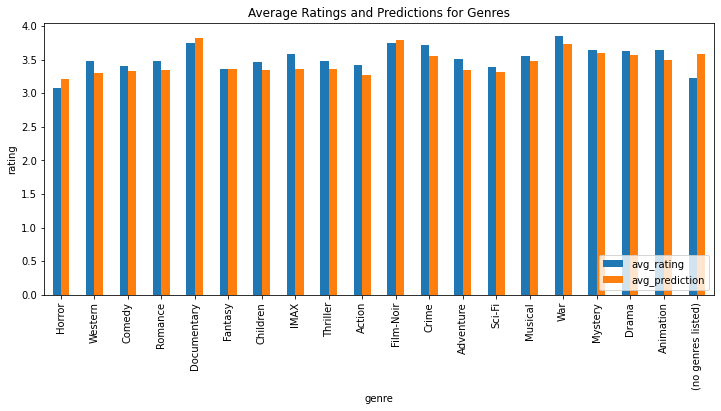

with 0.5_0.5 split, the plot of distribution is: 


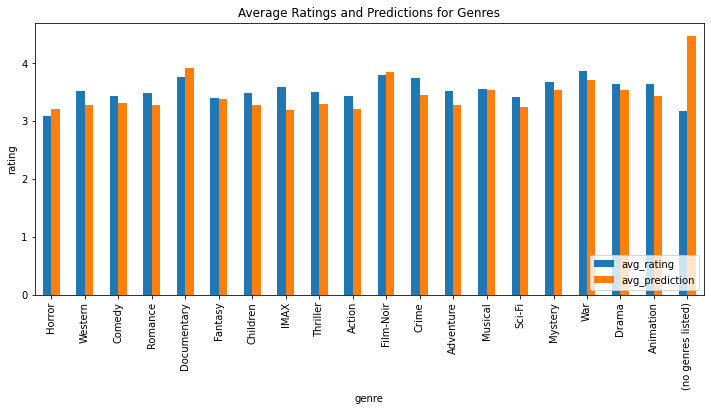

with 0.25_0.75 split, the plot of distribution is: 


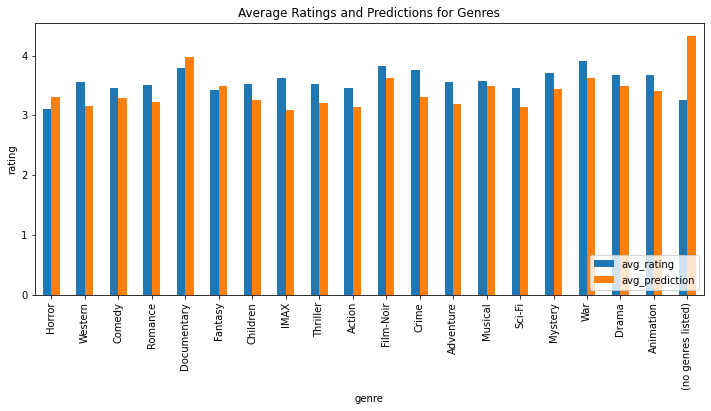

In [50]:
plot_genre(splits, 'modelbased', predictions)

## The Loss User

In [51]:
predictions_spark = loading(spark, path.join(data_path, 'processed', 'prediction'))

In [52]:
def loss_user(with_pred,minloss=True):
    with_se = with_pred.withColumn("SE",(with_pred.rating - with_pred.prediction)**2)
    with_mse = with_se.groupBy("userID").agg(F.mean("SE").alias("MSE")).orderBy("MSE",ascending=minloss)
    user = with_mse.take(1)[0][0]
    mse = with_mse.take(1)[0][1]
    print("MSE for this user is: "+str(mse))
    return with_pred[with_pred.userId == user]

def loss_user_pipeline(splits, model, predictions):
    for s in splits:
        print(f'with {s} split, the plot of distribution is: ')
        k = s + '_' + model + '_' + 'pred'
        display(loss_user(predictions_spark[k], False).toPandas())

### The Loss User for Baseline Model

In [53]:
loss_user_pipeline(splits, 'baseline', predictions)

with 0.75_0.25 split, the plot of distribution is: 
MSE for this user is: 14.22008875266121


,userId,movieId,rating,prediction
0,69944,1148,0.5,4.270953294945618


with 0.5_0.5 split, the plot of distribution is: 
MSE for this user is: 15.309508417715978


,userId,movieId,rating,prediction
0,62349,47099,0.5,4.388674884437596
1,62349,79132,0.5,4.5699588477366255
2,62349,1270,0.5,4.485181173690429
3,62349,84772,0.5,4.197297297297297


with 0.25_0.75 split, the plot of distribution is: 
MSE for this user is: 15.903924768004282


,userId,movieId,rating,prediction
0,51926,750,0.5,4.492483946293053
1,51926,58559,0.5,4.46920401854714
2,51926,6016,0.5,4.505054832076764
3,51926,912,0.5,4.485062893081761


In [54]:
#todo analysis

### The Loss User for User Based CF

In [55]:
loss_user_pipeline(splits, 'userbased', predictions)

with 0.75_0.25 split, the plot of distribution is: 
MSE for this user is: 18.467031298210507


,userId,movieId,rating,prediction
0,69944,1148,0.5,4.797328390780778


with 0.5_0.5 split, the plot of distribution is: 
MSE for this user is: 20.86403937708827


,userId,movieId,rating,prediction
0,62349,1270,0.5,5.1528074517802445
1,62349,79132,0.5,5.2654623142482055
2,62349,47099,0.5,5.021212557149697
3,62349,84772,0.5,4.81932243176674


with 0.25_0.75 split, the plot of distribution is: 
MSE for this user is: 19.676895643542245


,userId,movieId,rating,prediction
0,49194,912,5.0,0.579267859880497
1,49194,750,5.0,0.5193390831506722
2,49194,111,5.0,0.6206676978108528
3,49194,3504,5.0,0.5379560451845535


In [56]:
#todo analysis

### The Loss User for Item Based CF

In [57]:
loss_user_pipeline(splits, 'itembased', predictions)

with 0.75_0.25 split, the plot of distribution is: 
MSE for this user is: 19.351978258550428


,userId,movieId,rating,prediction
0,69944,1148,0.5,4.89908834402657


with 0.5_0.5 split, the plot of distribution is: 
MSE for this user is: 22.011493817079305


,userId,movieId,rating,prediction
0,62349,1270,0.5,5.341285069358161
1,62349,79132,0.5,5.334921665741634
2,62349,47099,0.5,5.111705387519026
3,62349,84772,0.5,4.968068939754298


with 0.25_0.75 split, the plot of distribution is: 
MSE for this user is: 23.1155296980304


,userId,movieId,rating,prediction
0,51134,79132,0.5,5.45688832138639
1,51134,68954,0.5,5.269363097387826
2,51134,68157,0.5,5.193508592585043


In [58]:
#todo analysis

### The Loss User for Model Based CF

In [59]:
loss_user_pipeline(splits, 'modelbased', predictions)

with 0.75_0.25 split, the plot of distribution is: 
MSE for this user is: 18.410484073536


,userId,movieId,rating,prediction
0,228223,6953,1.0,5.290744


with 0.5_0.5 split, the plot of distribution is: 
MSE for this user is: 17.45689098442716


,userId,movieId,rating,prediction
0,178143,56174,5.0,0.33659577
1,178143,68157,4.0,0.37144065


with 0.25_0.75 split, the plot of distribution is: 
MSE for this user is: 22.64512543091711


,userId,movieId,rating,prediction
0,49194,912,5.0,0.28520924
1,49194,111,5.0,0.15510705
2,49194,3504,5.0,0.34194395
3,49194,750,5.0,0.18535817


In [60]:
#todo analysis